In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.callbacks import TFMProgressBar
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, XGBModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
from darts.timeseries import concatenate
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [3]:
length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (
    tg.sine_timeseries(length=length, value_frequency=0.02)
    + tg.constant_timeseries(length=length, value=1)
) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

<Axes: xlabel='time'>

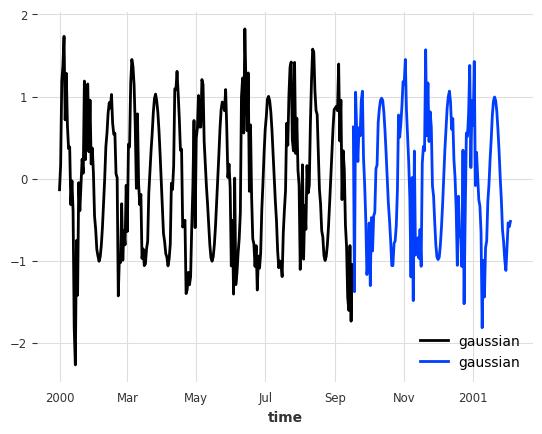

In [4]:
target_train.plot()
target_val.plot()

In [72]:
my_model = XGBModel(
    lags=10,
    lags_future_covariates=[1, 2, 3,],
    likelihood='quantile'
)

my_model.fit(target_train, future_covariates=covariates)

XGBModel(lags=10, lags_past_covariates=None, lags_future_covariates=[1, 2, 3], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [132]:
my_model.save("abc.pt")

matplotlib.axes._axes.Axes

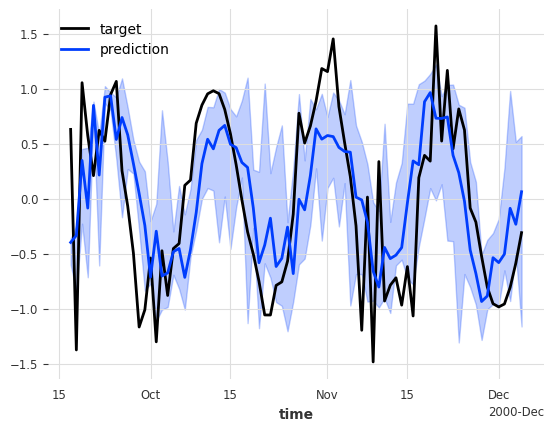

In [86]:
pred = my_model.predict(80, num_samples=5)
target_val.slice_intersect(pred).plot(label="target")
pred.plot(label="prediction")

In [76]:
impo = my_model.model.get_booster().get_score(importance_type='weight')

In [133]:
pd.DataFrame(index=pred.time_index, data=pred.data_array()[:, 0, :].as_numpy())

,0,1,2,3,4
time,,,,,
2000-09-17,-0.399016,-0.608515,-0.569536,-0.372289,-0.362378
2000-09-18,-0.236351,-0.956285,-0.391370,-0.335614,-0.273385
2000-09-19,0.468251,-0.331404,0.182707,0.346009,0.381292
2000-09-20,0.453755,0.463443,-0.086927,-0.852150,-0.170239
2000-09-21,0.846735,0.864993,0.789645,0.730922,0.884707
...,...,...,...,...,...
2000-12-01,-0.695076,-0.582551,-0.520690,-1.041097,-0.102414
2000-12-02,-0.666347,-0.505097,-0.404931,-0.599616,0.444859
2000-12-03,-0.457866,1.114611,-1.050448,-0.088948,0.431984


In [128]:
pred.data_array()[:, 0, :].as_numpy()

<xarray.DataArray (time: 80, sample: 5)> Size: 3kB
array([[-0.39901572, -0.60851499, -0.56953638, -0.3722891 , -0.36237835],
       [-0.23635075, -0.95628484, -0.39137016, -0.3356144 , -0.2733848 ],
       [ 0.46825118, -0.3314041 ,  0.18270675,  0.34600915,  0.38129159],
       [ 0.45375471,  0.46344339, -0.08692664, -0.85215027, -0.17023926],
       [ 0.84673503,  0.86499324,  0.78964536,  0.73092157,  0.88470721],
       [ 0.55286803, -0.54938516,  0.59180535,  0.21326232, -0.62322569],
       [ 0.8958332 ,  1.03066366,  0.92141629,  0.98611266,  0.86204968],
       [ 0.96175431,  0.78597499,  0.93366222,  0.96026659,  0.8400004 ],
       [ 0.33414315,  0.46925602,  0.53680935,  0.75684979,  0.9611905 ],
       [ 0.73645647,  1.1778489 ,  0.74940729, -0.13930007, -0.17795128],
       [ 0.86485642,  0.57848805,  0.66763799,  0.27598492,  0.26685258],
       [ 0.36461764,  0.31687615,  0.57413039,  0.29904351,  0.20804164],
       [-0.08781007,  0.10210205,  0.04631196,  0.39289312, -0.3368838 ],
       [ 0.09302794, -0.36310804, -0.24449051,  0.28617989, -0.95673809],
       [-0.76454028, -0.16869183, -0.77576709, -0.35562464, -0.71431647],
       [-1.17099327, -0.03445291, -0.88100324, -0.10507362, -0.29710012],
       [-1.03618049,  1.10923054, -0.90885506, -0.42545136, -0.70422053],
       [-0.97012522, -0.67670671, -0.99018554, -0.66574858,  0.58318367],
       [-0.72028374, -0.29772525, -0.30579409, -0.48315617, -0.58443359],
       [-0.89672652, -0.45418636, -0.51330391,  0.12513975,  0.07025845],
...
       [ 0.80875164, -0.43684679, -0.86901079,  0.34170517,  0.87552487],
       [ 0.30727592, -0.05742636, -0.53220103,  0.49009882,  1.17651744],
       [ 0.87999803,  0.2217688 , -0.27653104,  0.92998519,  1.10756893],
       [ 0.96310751,  1.17029628, -0.0833736 ,  0.9836993 ,  0.80682962],
       [-0.0692686 ,  0.19362004,  1.25064838,  1.09349588,  0.73037552],
       [ 0.33419378,  0.72769051,  0.95889101,  0.8234287 ,  0.07863612],
       [ 0.74157841,  0.88613467,  0.66608008,  1.06951831, -0.64462246],
       [ 0.39249233,  0.72190438,  1.11411323, -0.40288699, -0.32741636],
       [ 0.2525036 , -1.40628648,  1.00285266,  0.23511845, -0.91820187],
       [-0.10206165,  0.27111229,  0.96381092, -0.02503207, -0.83278342],
       [-0.4679787 ,  0.20756429,  0.36259689, -0.61043616, -0.85485471],
       [-0.71730646, -0.17129162,  0.23263441, -0.68127711, -1.02708305],
       [-0.93639694, -0.41512036, -1.36880701, -0.95408691, -0.90372633],
       [-0.90395487, -0.78304091, -0.27416238, -1.03350137, -0.8859976 ],
       [-0.27848381, -0.53812101, -0.64658324, -1.03811771, -0.4573696 ],
       [-0.69507614, -0.58255134, -0.52069   , -1.04109673, -0.10241428],
       [-0.66634671, -0.50509746, -0.40493063, -0.59961569,  0.44485936],
       [-0.45786587,  1.11461101, -1.05044787, -0.08894803,  0.4319841 ],
       [-0.34109534,  0.69143643, -0.53373385, -0.23410793, -0.19251071],
       [ 0.23051838,  0.6515761 , -1.00330172,  0.06165748, -1.2033329 ]])
Coordinates:
  * time       (time) datetime64[ns] 640B 2000-09-17 2000-09-18 ... 2000-12-05
    component  <U8 32B 'gaussian'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [126]:
pred.time_index.shape

(80,)

In [79]:
my_model.lagged_feature_names

['gaussian_target_lag-10',
 'gaussian_target_lag-9',
 'gaussian_target_lag-8',
 'gaussian_target_lag-7',
 'gaussian_target_lag-6',
 'gaussian_target_lag-5',
 'gaussian_target_lag-4',
 'gaussian_target_lag-3',
 'gaussian_target_lag-2',
 'gaussian_target_lag-1',
 'sine_futcov_lag1',
 'sine_futcov_lag2',
 'sine_futcov_lag3']

In [83]:
impo.keys()

dict_keys(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f12'])

In [107]:
names = list(reversed(my_model.lagged_feature_names[0:10])) + my_model.lagged_feature_names[-3:]
names = ['_'.join(n.split("_")[1:]) for n in names]
impos = my_model.model.feature_importances_

In [100]:
impo

{'f0': 227.0,
 'f1': 70.0,
 'f2': 42.0,
 'f3': 53.0,
 'f4': 2.0,
 'f5': 1.0,
 'f6': 83.0,
 'f7': 66.0,
 'f8': 16.0,
 'f9': 178.0,
 'f10': 14.0,
 'f12': 2.0}

In [99]:
len(names), len(impo)

(13, 12)

In [130]:
names, impos

(['target_lag-1',
  'target_lag-2',
  'target_lag-3',
  'target_lag-4',
  'target_lag-5',
  'target_lag-6',
  'target_lag-7',
  'target_lag-8',
  'target_lag-9',
  'target_lag-10',
  'futcov_lag1',
  'futcov_lag2',
  'futcov_lag3'],
 array([0.05224478, 0.06726032, 0.11285008, 0.0809709 , 0.1434282 ,
        0.06398024, 0.07157374, 0.072703  , 0.11543964, 0.05575984,
        0.11195413, 0.        , 0.05183521], dtype=float32))

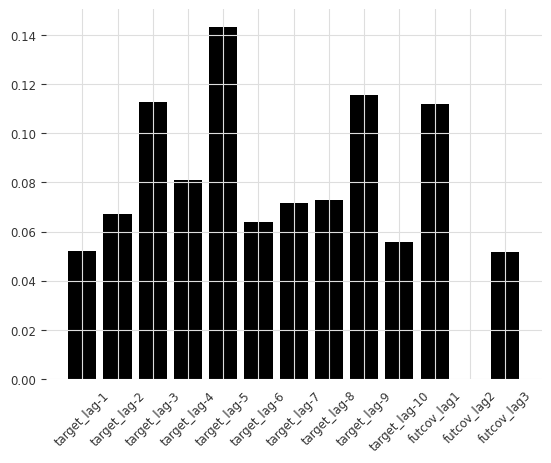

In [108]:
from matplotlib import pyplot

pyplot.bar(names, impos)
plt.xticks(rotation=45)
pyplot.show()

In [42]:
from darts.explainability import ShapExplainer

explainer = ShapExplainer(my_model)  # requires `background` if model was trained on multiple series

explain_results = explainer.explain()

exlained_fc = explain_results.get_explanation(horizon=1)
feature_values = explain_results.get_feature_values(horizon=1)
shap_objects = explain_results.get_shap_explanation_object(horizon=1)

In [45]:
exlained_fc

<TimeSeries (DataArray) (time: 256, component: 8, sample: 1)> Size: 8kB
array([[[ 0.01808485],
        [ 0.005398  ],
        [-0.03063728],
        ...,
        [ 0.03736996],
        [-0.00144372],
        [-0.03214887]],

       [[ 0.01350596],
        [ 0.02445327],
        [ 0.12895125],
        ...,
        [ 0.05820521],
        [ 0.00057167],
        [-0.02466205]],

       [[ 0.00349083],
        [-0.06920683],
        [ 0.0759932 ],
        ...,
...
        ...,
        [-0.02183836],
        [-0.08559545],
        [-0.04878631]],

       [[ 0.073966  ],
        [-0.00170154],
        [-0.02229607],
        ...,
        [ 0.00732005],
        [ 0.04456834],
        [-0.04391281]],

       [[ 0.15502533],
        [ 0.198521  ],
        [-0.00103199],
        ...,
        [ 0.15551265],
        [ 0.03334595],
        [-0.03665741]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2000-01-06 2000-01-07 ... 2000-09-17
  * component  (component) <U21 672B 'gaussian_target_lag-5' ... 'sine_futcov...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [41]:
from shap.plots import initjs
initjs()
explainer.force_plot_from_ts(target_train, foreground_future_covariates=covariates)

We can see that, on top of correctly predicting the, granted, simple oscillatory behavior of the target, the RNN correctly expresses more uncertainty in its predictions when the noise component is higher.

## Daily energy production

<Axes: xlabel='time'>

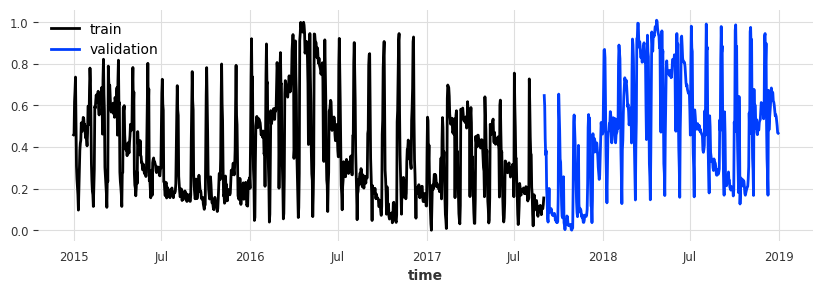

In [7]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# convert to float32
series_en = series_en.astype(np.float32)

# create train and test splits
train_en, val_en = series_en.split_after(pd.Timestamp("20170901"))

# scale
scaler_en = Scaler()
train_en_transformed = scaler_en.fit_transform(train_en)
val_en_transformed = scaler_en.transform(val_en)
series_en_transformed = scaler_en.transform(series_en)

# add the day as a covariate (no scaling required as the day is one-hot-encoded)
day_series = datetime_attribute_timeseries(
    series_en, attribute="day", one_hot=True, dtype=np.float32
)

plt.figure(figsize=(10, 3))
train_en_transformed.plot(label="train")
val_en_transformed.plot(label="validation")

In [8]:
model_name = "LSTM_test"
model_en = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=300,
    input_chunk_length=300,
    likelihood=GaussianLikelihood(),
    model_name=model_name,
    save_checkpoints=True,  # store the latest and best performing epochs
    force_reset=True,
    **generate_torch_kwargs(),
)


In [11]:
model_en.fit(
    series=train_en_transformed,
    future_covariates=day_series,
    val_series=val_en_transformed,
    val_future_covariates=day_series,
)

Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 63.47it/s, train_loss=-1.25, val_loss=-0.958]  


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.2, training_length=300, batch_size=16, n_epochs=10, optimizer_kwargs={'lr': 0.001}, random_state=0, input_chunk_length=300, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), model_name=LSTM_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x72e806f97ce0>]})

Let's load the model at the best performing state

In [12]:
model_en = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

Now we perform historical forecasts:
- we start predictions at the beginning of the validation series (`start=val_en_transformed.start_time()`)
- each prediction will have length `forecast_horizon=30`.
- the next prediction will start `stride=30` points ahead
- we keep all predicted values from each forecast (`last_points_only=False`) 
- continue until we run out of input data

In the end we concatenate the historical forecasts to get a single continuous (on time axis) time series

In [13]:
backtest_en = model_en.historical_forecasts(
    series=series_en_transformed,
    future_covariates=day_series,
    start=val_en_transformed.start_time(),
    num_samples=500,
    forecast_horizon=30,
    stride=30,
    retrain=False,
    verbose=True,
    last_points_only=False,
)
backtest_en = concatenate(backtest_en, axis=0)

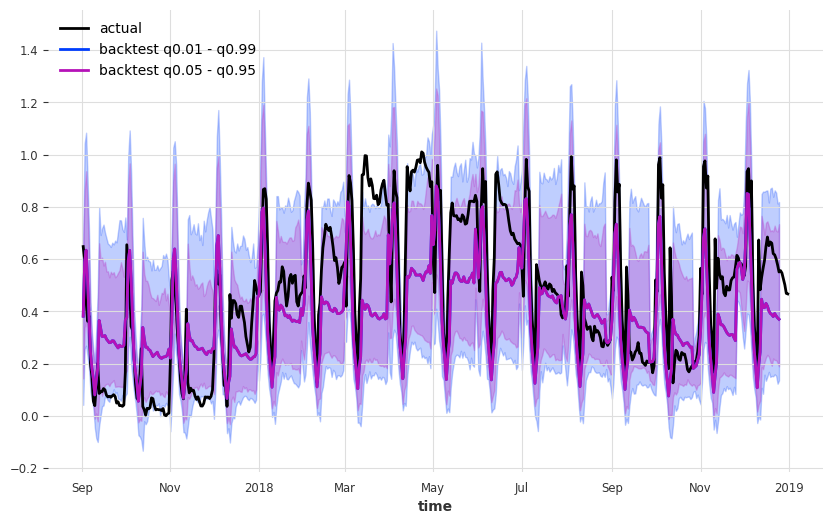

In [14]:
plt.figure(figsize=(10, 6))
val_en_transformed.plot(label="actual")
backtest_en.plot(label="backtest q0.01 - q0.99", low_quantile=0.01, high_quantile=0.99)
backtest_en.plot(label="backtest q0.05 - q0.95", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [16]:
from darts.explainability import ShapExplainer

explainer = ShapExplainer(model_en)  # requires `background` if model was trained on multiple series

explain_results = explainer.explain()

exlained_fc = explain_results.get_explanation(horizon=1)
feature_values = explain_results.get_feature_values(horizon=1)
shap_objects = explain_results.get_shap_explanation_objects(horizon=1)

ValueError: Invalid `model` type. Currently, only models of type `RegressionModel` are supported.